# [Clever Title]

## [Cool Subtitle]

### Project Members: Diana Chou, Max Scribner, Lewis Qualkenbush

### Table of Contents:

<ol>
    <li>Introduction</li>
    <li>Data Munging</li>
    <li>Data Exploration and Analysis</li>
    <li>Conclusion</li>
</ol>

### Introduction

*Introduction Text*

### Data Wrangling

#### Reading the Data

In [1]:
import numpy as np
import pandas as pd
import re

pd.options.display.max_columns = None

In [2]:
# Read the CSV into a new dataframe
transcriptions = pd.read_csv("transcriptions/british.csv")

# We want to remove characters we do not want to perform analysis on
transcriptions = transcriptions.replace(to_replace='\'|:|ˌ', value = '', regex = True)
transcriptions['word'] = transcriptions['word'].str.lower()
transcriptions = transcriptions[['word', 'transcription']]

#### Find Unique Characters for Analysis

In [3]:
from functools import reduce

In [4]:
def get_chars(string):
    chars = set()
    
    for char in string:
        chars.add(char.lower())
        
    return chars

orth_chars = set()
phon_chars = set()

# Get unique characters for both letters and phonemes from the dataset
for index, row in transcriptions.iterrows():
    orth_chars = orth_chars.union(get_chars(row["word"]))
    
    phon_chars = phon_chars.union(get_chars(row["transcription"]))

In [5]:
print(orth_chars)
print(phon_chars)

{'e', 'm', 'y', 'i', 'w', 'h', 'o', 'g', 'u', 'z', 'p', 'b', 'd', 'a', 'k', 's', 'v', 'c', 'r', 'f', 'q', 'l', 'j', 't', 'x', 'n'}
{'e', 'ɑ', 'ʌ', 'ʒ', 'n', 'p', 'b', 'd', 'ʃ', 'l', 't', 'm', 'ð', 'i', 'w', 'h', 'g', 'ɒ', 'z', 'u', 'a', 'ɔ', 'ə', 'k', 's', 'ʊ', 'v', 'ŋ', 'ɪ', 'r', 'æ', 'f', 'θ', 'ɜ', 'j'}


#### Finding the Distributions of Letters and Phonemes Within the Data

In [6]:
orth_list = list(orth_chars)
phon_list = list(phon_chars)
orth_list.sort()
phon_list.sort()

orth_prob = {k: 0 for k in orth_list}
phon_prob = {k: 0 for k in phon_list}

In [7]:
# Count the number of times a letter or phoneme appears within the dataset
for index, row in transcriptions.iterrows():
    for orth in list(row['word']):
        orth_prob[orth] += 1
    
    for phon in list(row['transcription']):
        phon_prob[phon] += 1

In [8]:
# Normalize the distribution values of letters and phonemes
orth_prob_max = max(orth_prob.values())
phon_prob_max = max(phon_prob.values())

orth_prob = {k: (v/orth_prob_max) for k, v in orth_prob.items()}
phon_prob = {k: (v/phon_prob_max) for k, v in phon_prob.items()}

### Data Exploration

#### Intra-Word Co-Occurence Map

We are going to start our exploration by finding how often each phoneme co-occurs within a word with a given letter.

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
hm_orth_dict = {k: v for v, k in enumerate(orth_list)}
hm_phon_dict = {k: v for v, k in enumerate(phon_list)}

# Create a new dataframe to hold the values for the heatmap
heatmap_frame = pd.DataFrame(index=[i for i in range(0, len(hm_phon_dict))], 
                             columns=[i for i in range(0, len(hm_orth_dict))], 
                             data=0)

In [11]:
# Loop through each word, transcription pair in the dataset
for index, row in transcriptions.iterrows():
    word_length = len(row['word'])
    transcription_length = len(row['transcription'])
    
    # Calculate the weight we want to add to that pairing given the current lengths
    # of the word and transcription
    weight = word_length * transcription_length
    weighted_val = float(1/weight)
    
    for orth in list(row['word']):
        for phon in list(row['transcription']):
            # Calculate the weighting based on the distribution of a given letter
            # and phoneme
            dist_weight = float(1/(orth_prob[orth] * phon_prob[phon]))
            
            # Add this weighted value to the heatmap for the given pair
            heatmap_frame.loc[[hm_phon_dict[phon]],[hm_orth_dict[orth]]] += (weighted_val * dist_weight)

In [12]:
heatmap_frame.index = phon_list
heatmap_frame.columns = orth_list

# Normalize the values in the dataframe so they are on a scale from zero to one
max_val = max(heatmap_frame.max())
heatmap_frame = heatmap_frame.div(max_val)

heatmap_frame.head()

,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z
a,0.003969,0.029146,0.020202,0.041956,0.028675,0.030850,0.025134,0.039240,0.077253,0.000000,0.019858,0.018102,0.019085,0.026525,0.023975,0.010152,0.055852,0.023199,0.016880,0.024855,0.038554,0.021370,0.069365,0.009917,0.071428,0.091077
b,0.026105,0.314658,0.010760,0.029997,0.023149,0.005475,0.028019,0.015855,0.018936,0.070961,0.036696,0.027139,0.010571,0.012811,0.035623,0.004396,0.000000,0.028128,0.013098,0.020640,0.039363,0.016647,0.017364,0.027293,0.047514,0.000000
d,0.029121,0.030818,0.014793,0.173704,0.025441,0.013599,0.034090,0.016395,0.024379,0.140541,0.016026,0.019247,0.010513,0.026312,0.030128,0.011865,0.000000,0.028298,0.019259,0.007900,0.026748,0.009664,0.025009,0.003288,0.028218,0.000000
e,0.048074,0.024077,0.017674,0.029986,0.042354,0.016052,0.038056,0.024838,0.016273,0.011645,0.020648,0.030258,0.022414,0.026550,0.006800,0.029088,0.018325,0.024122,0.029427,0.028371,0.005576,0.036216,0.026950,0.034691,0.056871,0.021834
f,0.028531,0.005474,0.013013,0.014059,0.026828,0.339069,0.027892,0.017514,0.033590,0.000000,0.013025,0.043404,0.019208,0.014356,0.037587,0.003560,0.000000,0.034527,0.011665,0.023769,0.034573,0.016151,0.013577,0.054065,0.010556,0.040549


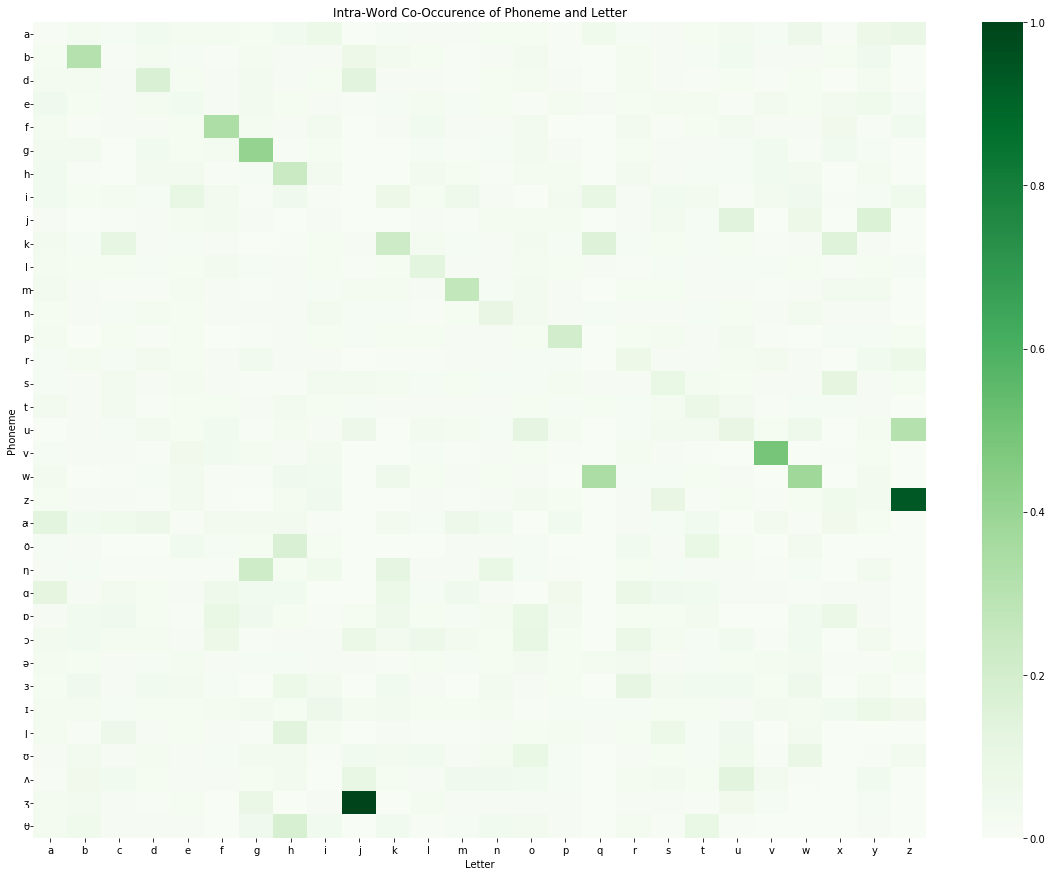

In [13]:
# Plot the dataframe showing the co-occurence values of each phoneme, letter pair
plt.subplots(figsize=(20,15))
ax = sns.heatmap(heatmap_frame, cmap="Greens")
plt.yticks(rotation=0, va="center", ha="center")
ax.set_title('Intra-Word Co-Occurence of Phoneme and Letter'), ax.set_ylabel('Phoneme'), ax.set_xlabel('Letter')
plt.show()

In [14]:
# Find the letter of greatest co-occurence for each phoneme
phon_comax = heatmap_frame.idxmax(axis=1).to_frame()
phon_comax.transpose()

,a,b,d,e,f,g,h,i,j,k,l,m,n,p,r,s,t,u,v,w,z,æ,ð,ŋ,ɑ,ɒ,ɔ,ə,ɜ,ɪ,ʃ,ʊ,ʌ,ʒ,θ
0,z,b,d,y,f,g,h,q,y,k,l,m,n,p,z,x,t,z,v,w,z,a,h,g,a,f,o,o,r,y,h,o,u,j,h


In [15]:
# Find the phoneme of greatest co-occurence for each letter
orth_comax = heatmap_frame.idxmax(axis=0).to_frame()
orth_comax.transpose()

,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z
0,æ,b,k,d,i,f,g,h,a,ʒ,k,l,m,n,u,p,w,ɜ,z,θ,j,v,w,k,j,z


#### Finding Clusters Within Words

In [16]:
import math

In [17]:
# Manual listing of consonants and vowels for orthrographical British English
orth_consonants = ['l', 't', 'f', 'm', 'n', 'v', 'p', 'h', 'j', 'w', 'r', 'b', 'x', 'c', 'q', 'z',  'g', 's', 'k', 'd']
orth_consonants.sort()
orth_vowels = ['i', 'a', 'o', 'e', 'y', 'u']
orth_vowels.sort()

# Manual listing of consonants and vowels for phonological British English
phon_consonants = ['t', 'f', 'd', 'p', 'h', 'ʃ', 'r', 'b', 'θ', 'ŋ', 'g', 'k', 'ʒ', 'l', 'm', 'n', 'v', 'j', 'w', 'ð', 's', 'z']
phon_consonants.sort()
phon_vowels = ['ɑ', 'a', 'ɜ', 'ʊ', 'æ', 'e', 'ə', 'u', 'i', 'ɪ', 'ʌ', 'ɔ', 'ɒ']
phon_vowels.sort()

In [18]:
# Returns the word as a list of strings representing its clusters
# word - word to turn into a list of cluster(letters)-sound(consonant or vowel) pairs
# is_orth - true if word is orthological, false is word is phonemic
def get_cluster(word, is_orth):
    cluster = []
    diff = 0
    if (is_orth):
        consonants = orth_consonants
        vowels = orth_vowels
    else:
        consonants = phon_consonants
        vowels = phon_vowels
        
    for i in range(len(word)):
        if word[i] in consonants:
            cluster.append(([word[i]],'c'))
            
        else:
            cluster.append(([word[i]],'v'))
    
    for c in cluster:
        if c[1] == 'c': 
            diff = diff + 1
        else: 
            diff = diff - 1
    
    while (abs(diff) > 1):
        diff = 0
        #print(cluster) # view each step before re-clustering        
        cluster = re_cluster(cluster)  
        for c in cluster:
            if c[1] == 'c': 
                diff = diff + 1
            else: 
                diff = diff - 1
    re_cluster(cluster)
    
    return cluster

def re_cluster(cluster):
    for j in range(len(cluster)):
        if (j > 0):
            if (cluster[j][1] == cluster[j-1][1]):
                cluster[j-1] = (cluster[j-1][0] + cluster[j][0], cluster[j][1]) 
                cluster[j] = 'drop'
    
    cluster[:] = [x for x in cluster if x != 'drop']
    
    return cluster

In [19]:
# Testing get_cluster() on various words
o_words = ['stood', 'breakfast', 'computer', 'listen', 'rubber', 'without']
p_words = ['stʊd', 'brekfəst', 'kəmpjutə', 'lɪsən', 'rʌbə', 'wɪðaʊt']

for i in range(len(o_words)):
    print('\n' + o_words[i])
    print(get_cluster(o_words[i], True))
    print(get_cluster(p_words[i], False))


stood
[(['s', 't'], 'c'), (['o', 'o'], 'v'), (['d'], 'c')]
[(['s', 't'], 'c'), (['ʊ'], 'v'), (['d'], 'c')]

breakfast
[(['b', 'r'], 'c'), (['e', 'a'], 'v'), (['k', 'f'], 'c'), (['a'], 'v'), (['s', 't'], 'c')]
[(['b', 'r'], 'c'), (['e'], 'v'), (['k', 'f'], 'c'), (['ə'], 'v'), (['s', 't'], 'c')]

computer
[(['c'], 'c'), (['o'], 'v'), (['m', 'p'], 'c'), (['u'], 'v'), (['t'], 'c'), (['e'], 'v'), (['r'], 'c')]
[(['k'], 'c'), (['ə'], 'v'), (['m', 'p', 'j'], 'c'), (['u'], 'v'), (['t'], 'c'), (['ə'], 'v')]

listen
[(['l'], 'c'), (['i'], 'v'), (['s', 't'], 'c'), (['e'], 'v'), (['n'], 'c')]
[(['l'], 'c'), (['ɪ'], 'v'), (['s'], 'c'), (['ə'], 'v'), (['n'], 'c')]

rubber
[(['r'], 'c'), (['u'], 'v'), (['b', 'b'], 'c'), (['e'], 'v'), (['r'], 'c')]
[(['r'], 'c'), (['ʌ'], 'v'), (['b'], 'c'), (['ə'], 'v')]

without
[(['w'], 'c'), (['i'], 'v'), (['t', 'h'], 'c'), (['o', 'u'], 'v'), (['t'], 'c')]
[(['w'], 'c'), (['ɪ'], 'v'), (['ð'], 'c'), (['a', 'ʊ'], 'v'), (['t'], 'c')]


#### Preparing Data with Clustering

In [20]:
clustered_transcriptions = transcriptions.copy()

# Apply clustering function to words and transcriptions in dataframe
clustered_transcriptions.word = clustered_transcriptions.word.apply(get_cluster, args=(True,))
clustered_transcriptions.transcription = clustered_transcriptions.transcription.apply(get_cluster, args=(False,))

In [21]:
# Function to check compatibility of clustered words and their corresponding transcription
def cluster_compatible(word, transcription):
    # Are there the same number of clusters?
    if len(word) != len(transcription):
        return False
    
    # For each pair of clusters, do they have the same vowel or consonant typing?
    for index, tup in enumerate(word):
        if tup[1] != transcription[index][1]:
            return False
    
    # Return true if both of these questions are true
    return True

In [22]:
# Add a new column with the returned value of the cluster_compatible function
clustered_transcriptions['compatible'] = clustered_transcriptions.apply(
    lambda x: cluster_compatible(x.word, x.transcription), axis=1)

clustered_transcriptions.head()

,word,transcription,compatible
0,"[([a], v)]","[([e, ɪ], v)]",True
1,"[([a], v), ([b], c), ([o, u], v), ([t], c)]","[([ə], v), ([b], c), ([a, ʊ], v), ([t], c)]",True
2,"[([a], v), ([b], c), ([o], v), ([v], c), ([e],...","[([ə], v), ([b], c), ([ʌ], v), ([v], c)]",False
3,"[([a], v), ([c, r], c), ([o], v), ([s, s], c)]","[([ə], v), ([k, r], c), ([ɒ], v), ([s], c)]",True
4,"[([a], v), ([c, t], c)]","[([æ], v), ([k, t], c)]",True


In [23]:
# Pull out compatible tuples for heatmap analysis and incompatible tuples for later analysis
compatible_clust = clustered_transcriptions[clustered_transcriptions['compatible'] == True]
incompatible_clust = clustered_transcriptions[clustered_transcriptions['compatible'] == False]

In [24]:
# Flatten each column
word_clusters = [clust for row in compatible_clust.word for clust in row]
transcription_clusters = [clust for row in compatible_clust.transcription for clust in row]

# Join columns together into new flattened dataframe
flattened_clust = pd.DataFrame({'transcription': transcription_clusters, 'word': word_clusters})
# Create new type column based on typing of current tuple's clusters
flattened_clust['type'] = flattened_clust['word'].apply(lambda x: x[1])
# Pull out cluster from tuple
flattened_clust['word'] = flattened_clust['word'].apply(lambda x: x[0])
flattened_clust['transcription'] = flattened_clust['transcription'].apply(lambda x: x[0])

flattened_clust.head()

,transcription,word,type
0,"[e, ɪ]",[a],v
1,[ə],[a],v
2,[b],[b],c
3,"[a, ʊ]","[o, u]",v
4,[t],[t],c


In [25]:
# Create new dataframes for vowel and consonant clusters for analysis
vowel_clusters = flattened_clust[flattened_clust['type'] == 'v']
consonant_clusters = flattened_clust[flattened_clust['type'] == 'c']

#### Intra-Cluster Co-Occurence Map

In [26]:
vowel_orth_dict = {k: v for v, k in enumerate(orth_vowels)}
vowel_phon_dict = {k: v for v, k in enumerate(phon_vowels)}

# Create new dataframe for vowel heatmap
vowel_heatmap = pd.DataFrame(index=[i for i in range(0, len(vowel_phon_dict))], 
                             columns=[i for i in range(0, len(vowel_orth_dict))], 
                             data=0)

consonant_orth_dict = {k: v for v, k in enumerate(orth_consonants)}
consonant_phon_dict = {k: v for v, k in enumerate(phon_consonants)}

# Create new dataframe for consonant heatmap
consonant_heatmap = pd.DataFrame(index=[i for i in range(0, len(consonant_phon_dict))], 
                             columns=[i for i in range(0, len(consonant_orth_dict))], 
                             data=0)

In [27]:
# Run through each cluster and add acording weighted value
for index, row in vowel_clusters.iterrows():
    word_clust_length = len(row['word'])
    transcription_clust_length = len(row['transcription'])
    
    # Word length weight calculation
    weight = word_clust_length * transcription_clust_length
    weighted_val = float(1/weight)
    
    for orth in row['word']:
        for phon in row['transcription']:
            # Ditribution weight calulation
            dist_weight = float(1/(orth_prob[orth] * phon_prob[phon]))
            
            # Add new weighted value to overal for letter, phoneme pair
            vowel_heatmap.loc[[vowel_phon_dict[phon]],[vowel_orth_dict[orth]]] += (weighted_val * dist_weight)

# Apply same process to consonant data
for index, row in consonant_clusters.iterrows():
    word_clust_length = len(row['word'])
    transcription_clust_length = len(row['transcription'])
    
    weight = word_clust_length * transcription_clust_length
    weighted_val = float(1/weight)
    
    for orth in row['word']:
        for phon in row['transcription']:
            dist_weight = float(1/(orth_prob[orth] * phon_prob[phon]))
            
            consonant_heatmap.loc[[consonant_phon_dict[phon]],[consonant_orth_dict[orth]]] += (weighted_val * dist_weight)

In [28]:
# Change index and columns names and normalize dataframes
vowel_heatmap.index = phon_vowels
vowel_heatmap.columns = orth_vowels

vowel_max_val = max(vowel_heatmap.max())
vowel_heatmap = vowel_heatmap.div(vowel_max_val)

consonant_heatmap.index = phon_consonants
consonant_heatmap.columns = orth_consonants

consonant_max_val = max(consonant_heatmap.max())
consonant_heatmap = consonant_heatmap.div(consonant_max_val)

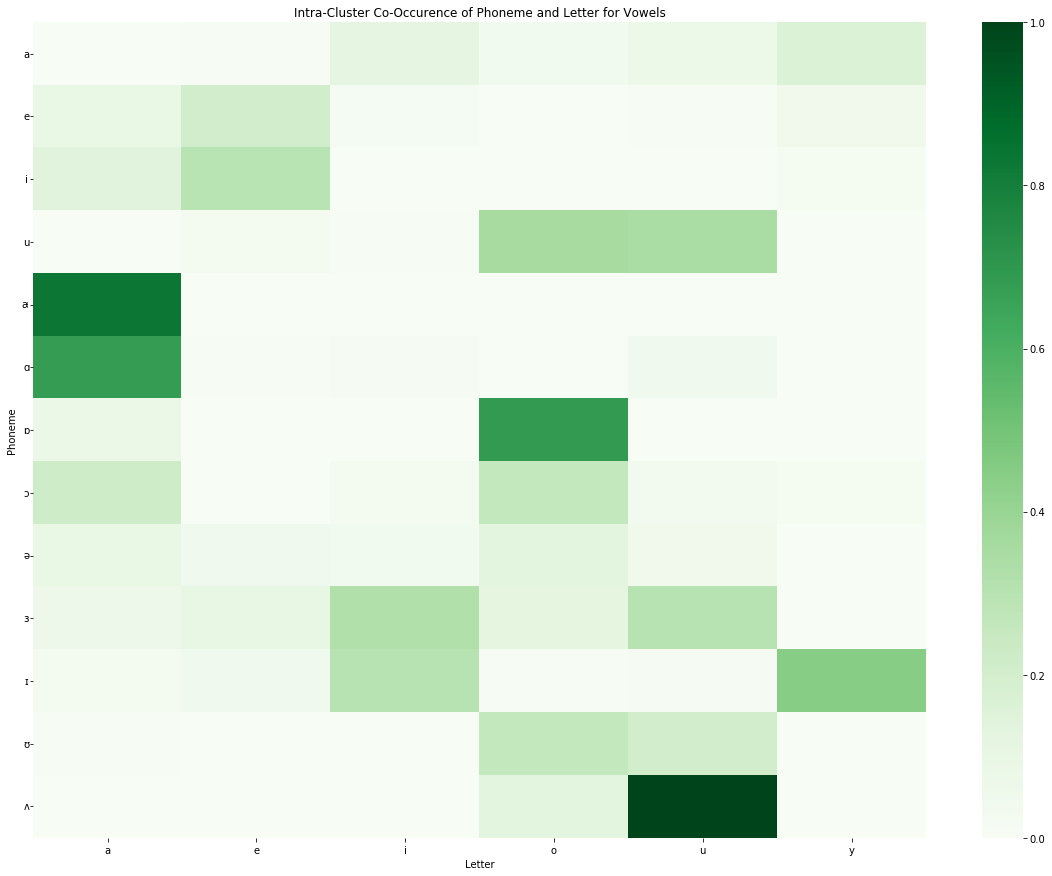

In [29]:
# Plot the dataframe showing the co-occurence values of each phoneme, letter pair
plt.subplots(figsize=(20,15))
ax_vowel = sns.heatmap(vowel_heatmap, cmap="Greens")
plt.yticks(rotation=0, va="center", ha="center")
ax_vowel.set_title('Intra-Cluster Co-Occurence of Phoneme and Letter for Vowels')
ax_vowel.set_ylabel('Phoneme'), ax_vowel.set_xlabel('Letter')
plt.show()

In [30]:
# Find the letter of greatest co-occurence for each phoneme
vowel_phon_comax = vowel_heatmap.idxmax(axis=1).to_frame()
vowel_phon_comax.transpose()

,a,e,i,u,æ,ɑ,ɒ,ɔ,ə,ɜ,ɪ,ʊ,ʌ
0,y,e,e,o,a,a,o,o,o,i,y,o,u


In [31]:
# Find the phoneme of greatest co-occurence for each letter
vowel_orth_comax = vowel_heatmap.idxmax(axis=0).to_frame()
vowel_orth_comax.transpose()

,a,e,i,o,u,y
0,æ,i,ɜ,ɒ,ʌ,ɪ


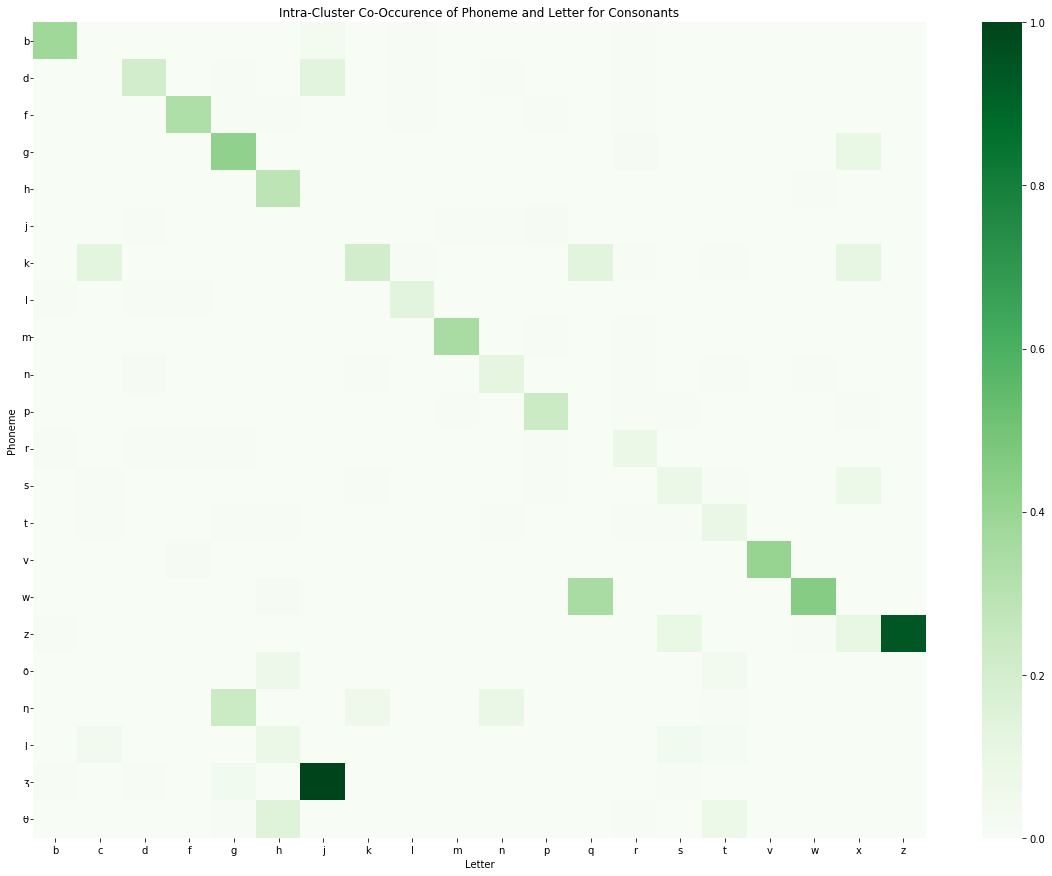

In [32]:
# Plot the dataframe showing the co-occurence values of each phoneme, letter pair
plt.subplots(figsize=(20,15))
ax_consonant = sns.heatmap(consonant_heatmap, cmap="Greens")
plt.yticks(rotation=0, va="center", ha="center")
ax_consonant.set_title('Intra-Cluster Co-Occurence of Phoneme and Letter for Consonants')
ax_consonant.set_ylabel('Phoneme'), ax_consonant.set_xlabel('Letter')
plt.show()

In [33]:
# Find the letter of greatest co-occurence for each phoneme
consonant_phon_comax = consonant_heatmap.idxmax(axis=1).to_frame()
consonant_phon_comax.transpose()

,b,d,f,g,h,j,k,l,m,n,p,r,s,t,v,w,z,ð,ŋ,ʃ,ʒ,θ
0,b,d,f,g,h,p,k,l,m,n,p,r,s,t,v,w,z,h,g,h,j,h


In [34]:
# Find the phoneme of greatest co-occurence for each letter
consonant_orth_comax = consonant_heatmap.idxmax(axis=0).to_frame()
consonant_orth_comax.transpose()

,b,c,d,f,g,h,j,k,l,m,n,p,q,r,s,t,v,w,x,z
0,b,k,d,f,g,h,ʒ,k,l,m,n,p,w,r,z,t,v,w,k,z
